In [59]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy
import os
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import sentencepiece as spm

* 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
* 학습된 모델로 sp_tokenize() 메소드 구현하기
* 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
* KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
* SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [102]:
train = pd.read_table('~/aiffel/sp_tokenizer/data/ratings.txt',sep='\t+')

/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [103]:
train['document']

0                                       어릴때보고 지금다시봐도 재밌어요ㅋㅋ
1         디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...
2                      폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
3         와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...
4                               안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.
                                ...                        
199995                                       포켓 몬스터 짜가 ㅡㅡ;;
199996                                                쓰.레.기
199997                    완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.
199998                  왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ
199999                                      포풍저그가나가신다영차영차영차
Name: document, Length: 200000, dtype: object

In [104]:
print(len(train['document']), train['document'].isnull().sum())

200000 0


In [106]:
train.duplicated().sum()

(0, 0)

### sentencepiece 학습 전에 전처리

In [107]:
import re

def preprocess_text(text):
    # 불용어
    text = re.sub(r'[^가-힣a-zA-Z0-9\s.?!]', '', text)
    
    # 영어가 있다면 소문자로 통일 
    text = text.lower()

    # 자음만 , 모음만 나오는 것들 삭제 (ㅋㅋ, ㅎㅎ, ㅠㅠ 등)
    text = re.sub(r'\b[ㄱ-ㅎㅏ-ㅣ]+\b', '', text)

    # 온점, 느낌표, 물음표가 여러 개 이어진 경우 1개로 통일 후 뒤에 공백 추가
    text = re.sub(r'[.]+', '. ', text)
    text = re.sub(r'[!]+', '! ', text)
    text = re.sub(r'[?]+', '? ', text)

    # 단어 길이가 15개 이상인 단어 삭제 (띄어쓰기 안 한) 
    text = ' '.join([word for word in text.split() if len(word) < 10])

    # 같은 단어가 3번 이상 반복되는 경우 삭제
    text = re.sub(r'(\b\w+)\1{2,}', '', text)

    # 중복 공백 하나로 통일 
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# 데이터프레임에 적용
train['document'] = train['document'].apply(preprocess_text)

In [108]:
train['text_length'] = train['document'].str.len()

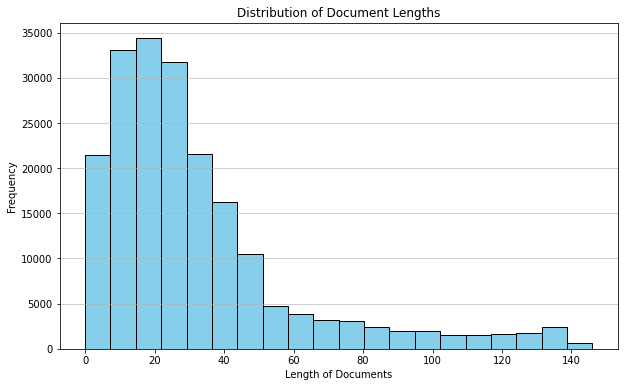

In [109]:
plt.figure(figsize=(10, 6))
plt.hist(train['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Document Lengths')
plt.xlabel('Length of Documents')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

### 공백 기준 토큰화

In [110]:
train[train['document'].str.split().apply(len) <= 1]

,id,document,label,text_length
8,7477618,굿,1.0,1
11,640794,재밌다,1.0,3
32,7295706,이범수연기쩜,1.0,6
49,10272889,내용이너무좋아요.,1.0,9
69,5784847,재미있어요,1.0,5
...,...,...,...,...
199946,735755,에혀,0.0,2
199969,6947256,착하다.,0.0,4
199975,307000,삐질삐질,0.0,4
199992,2228930,태권도?,0.0,4


In [111]:
from collections import Counter

all_text = " ".join(train['document'])

word_counts = Counter(all_text.split())

unique_word_count = len(word_counts)
print(f"vocab size : {unique_word_count}")

# 빈도 기반 상위 10개
word_counts.most_common(10)

vocab size : 377254


[('영화', 15797),
 ('너무', 11402),
 ('정말', 10993),
 ('진짜', 8596),
 ('영화.', 8089),
 ('이', 7145),
 ('.', 6667),
 ('그냥', 4650),
 ('이런', 4532),
 ('왜', 4519)]

In [112]:
pip show sentencepiece

Name: sentencepiece
Version: 0.1.96
Summary: SentencePiece python wrapper
Home-page: https://github.com/google/sentencepiece
Author: Taku Kudo
Author-email: taku@google.com
License: Apache
Location: /opt/conda/lib/python3.9/site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### LMS 환경 상에서 보캡 만들기가 에러나서 코랩에서 돌린뒤, 학습된 모델이랑 보캡 파일만 불러왔습니다.
* 왔다갔다가 힘들어서 사정 상 모델 타입은 전부 bpe

In [113]:
ls ~/aiffel/sp_tokenizer/model/

spm_model_16000.model  spm_model_16000.vocab


In [114]:
home_dir = os.path.expanduser("~")
home_dir

'/aiffel'

In [115]:
import tensorflow as tf
from sentencepiece import SentencePieceProcessor

# SentencePiece 모델 로드
spm_model_path = "/aiffel/aiffel/sp_tokenizer/model/spm_model_16000.model"
vocab_file_path = "/aiffel/aiffel/sp_tokenizer/model/spm_model_16000.vocab"

# SentencePieceProcessor 객체 생성
s = SentencePieceProcessor(model_file=spm_model_path)

# sp_tokenize 함수 정의
def sp_tokenize(s, corpus):
    tensor = []

    # 텍스트 데이터를 SentencePiece로 토크나이즈
    for sen in corpus:
        tensor.append(s.encode(sen, out_type=int))  # EncodeAsIds 방식으로 토크나이즈

    # 단어 사전 로드
    with open(vocab_file_path, 'r', encoding='utf-8') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    # 단어 사전을 인덱싱
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({word: idx})
        index_word.update({idx: word})

    # 패딩 
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

#### 출력은?

In [116]:
tensor, word_index, index_word = sp_tokenize(s, train['document'])

print("Tensor Shape:", tensor.shape)
print("Word Index Sample:", list(word_index.items())[:10])
print("Index Word Sample:", list(index_word.items())[:10])

tensor_df = pd.DataFrame(tensor)
print("Processed Tensor (First 5 Rows):")
print(tensor_df.head())

Tensor Shape: (200000, 82)
Word Index Sample: [('<unk>', 0), ('<s>', 1), ('</s>', 2), ('..', 3), ('영화', 4), ('▁영화', 5), ('▁이', 6), ('▁아', 7), ('...', 8), ('▁그', 9)]
Index Word Sample: [(0, '<unk>'), (1, '<s>'), (2, '</s>'), (3, '..'), (4, '영화'), (5, '▁영화'), (6, '▁이'), (7, '▁아'), (8, '...'), (9, '▁그')]
Processed Tensor (First 5 Rows):
      0      1     2      3      4     5      6      7      8      9   ...  \
0   1728    160   225   8841    802     0      0      0      0      0  ...   
1    722  15109  2121   4941   3488    33   2315  15204  11182  15122  ...   
2  14716    641  4452     41    252  2958     91   9577  15500   1075  ...   
3    317  15055   637     53  14446   395  15055   3140   9432   4352  ...   
4     40  15146    84  15611  15070  2389   6722  15067    682    206  ...   

   72  73  74  75  76  77  78  79  80  81  
0   0   0   0   0   0   0   0   0   0   0  
1   0   0   0   0   0   0   0   0   0   0  
2   0   0   0   0   0   0   0   0   0   0  
3   0   0   0   0  

### 82 확인이 필요하다

In [117]:
train = train.dropna(subset=['label']).reset_index(drop=True)
train['label'] = train['label'].astype(int)
train['label'].value_counts()

1    99996
0    99996
Name: label, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [118]:
# 1. train을 train, test 0.75,025 15만개,5만개로 
train_0, test_0 = train_test_split(train[train['label'] == 0], test_size=0.25, random_state=42)
train_1, test_1 = train_test_split(train[train['label'] == 1], test_size=0.25, random_state=42)

train = pd.concat([train_0, train_1]).reset_index(drop=True)
test = pd.concat([test_0, test_1]).reset_index(drop=True)

# train을 다시 train,val로 
train_0, val_0 = train_test_split(train[train['label'] == 0], test_size=0.2, random_state=42)
train_1, val_1 = train_test_split(train[train['label'] == 1], test_size=0.2, random_state=42)

train_data = pd.concat([train_0, train_1]).reset_index(drop=True)
val_data = pd.concat([val_0, val_1]).reset_index(drop=True)

* 임베딩

In [142]:
# 경로 재확인 & 재설정
spm_model_path = "/aiffel/aiffel/sp_tokenizer/model/spm_model_16000.model"
s = SentencePieceProcessor(model_file=spm_model_path)

def sp_tokenize(s, corpus):
    tensor = []
    for sen in corpus:
        tensor.append(s.encode(sen, out_type=int))  # Encode as IDs
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=150) # 분포상 그냥 150개로 퉁침
    return tensor

# 임베딩 
X_train = sp_tokenize(s, train_data['document'])
X_val = sp_tokenize(s, val_data['document'])
y_train = train_data['label'].values
y_val = val_data['label'].values
X_test = sp_tokenize(s, test['document'])[0]  # tensor만 가져오기
y_test = test['label'].values

In [143]:
def sp_tokenize(s, corpus, maxlen=150):  # maxlen 150 똑같이
    tensor = []

    for sen in corpus:
        tensor.append(s.encode(sen, out_type=int)) 

    with open(vocab_file_path, 'r', encoding='utf-8') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({word: idx})
        index_word.update({idx: word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)

    return tensor, word_index, index_word

In [144]:
X_test, _, _ = sp_tokenize(s, test['document'])
y_test = test['label'].values


print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}") 

X_test shape: (49998, 150)
y_test shape: (49998,)


### 에러에 대해 디버깅하기보단 걍 test에 맞춰서 함수 다시 짰다. 
* test셋에는 패딩 관련해서 데이터가 굉장히 듬성듬성하다. 당연히 데이터가 1/4 토막 났으니까. 

In [145]:
X_train.shape,y_train.shape

((119994, 150), (119994,))

### 모델이 무거울 필요는 없을듯
* 층 하나만 쌓고 진행

In [146]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# 최적 모델 콜백 
checkpoint = ModelCheckpoint(
    'best_model_sentence.h5',  
    monitor='val_accuracy',  # Val acc
    save_best_only=True,
    mode='max', 
    verbose=1 
)

model = Sequential([
    Embedding(input_dim=16000, output_dim=128, input_length=150),  # 임베딩 레이어
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=0.2)), # 한 층 후 
    Dense(1, activation='sigmoid')  # 바로 이진 분류 출력
])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 150, 128)          2048000   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 150, 256)          263168    
_________________________________________________________________
dense_14 (Dense)             (None, 150, 1)            257       
Total params: 2,311,425
Trainable params: 2,311,425
Non-trainable params: 0
_________________________________________________________________


In [147]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습
history = model.fit(
    X_train, 
    y_train, 
    epochs=8,  # 학습 반복 횟수
    batch_size=128,  # 배치 크기
    validation_data=(X_val, y_val), 
    callbacks=[checkpoint],  # 콜백 추가
    verbose=1  
)

loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Epoch 1/8
938/938 [==============================] - 32s 28ms/step - loss: 0.5474 - accuracy: 0.7424 - val_loss: 0.4816 - val_accuracy: 0.8055

Epoch 00001: val_accuracy improved from -inf to 0.80552, saving model to best_model_sentence.h5
Epoch 2/8
938/938 [==============================] - 25s 27ms/step - loss: 0.4670 - accuracy: 0.8073 - val_loss: 0.4774 - val_accuracy: 0.8121

Epoch 00002: val_accuracy improved from 0.80552 to 0.81210, saving model to best_model_sentence.h5
Epoch 3/8
938/938 [==============================] - 25s 26ms/step - loss: 0.4544 - accuracy: 0.8192 - val_loss: 0.4866 - val_accuracy: 0.7929

Epoch 00003: val_accuracy did not improve from 0.81210
Epoch 4/8
938/938 [==============================] - 25s 26ms/step - loss: 0.3926 - accuracy: 0.8434 - val_loss: 0.3796 - val_accuracy: 0.8318

Epoch 00004: val_accuracy improved from 0.81210 to 0.83177, saving model to best_model_sentence.h5
Epoch 5/8
938/938 [==============================] - 25s 26ms/step - loss: 

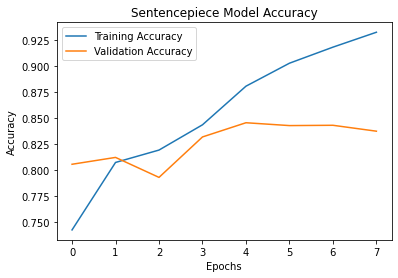

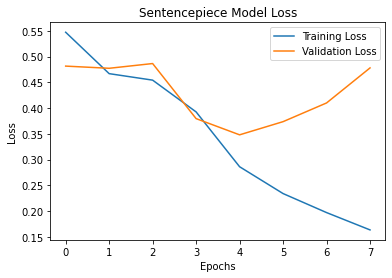

In [149]:
# Acc
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Sentencepiece Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Sentencepiece Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [132]:
best_model = load_model('best_model.h5')

# Test 데이터로 최적 모델 평가
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

1563/1563 [==============================] - 10s 6ms/step - loss: 0.6380 - accuracy: 0.8297
Test Loss: 0.6380, Test Accuracy: 0.8297


* 6 epoch 부터 과적합이 일어나는 것을 확인할 수 있다. 층을 한 개만 더 늘리면 85퍼까지는 갈 것으로 추측한다

### 동일한 모델에 이번엔 konlpy 토크나이저를 활용해서 비교분석해보자

### Mecab

In [41]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [151]:
# 매캡
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

mecab = Mecab() 

def tokenize_with_konlpy(sentence):
    return mecab.morphs(sentence)

X_train_tokens = train_data['document'].apply(lambda x: tokenize_with_konlpy(x))
X_val_tokens = val_data['document'].apply(lambda x: tokenize_with_konlpy(x))

tokenizer = Tokenizer(num_words=16000, oov_token="<OOV>")  # 단어 수 & OOV 처리
# 적용
tokenizer.fit_on_texts(X_train_tokens)

X_train_sequences = tokenizer.texts_to_sequences(X_train_tokens)
X_val_sequences = tokenizer.texts_to_sequences(X_val_tokens)

# 패딩
X_train_Mecab = pad_sequences(X_train_sequences, maxlen=150, padding='post')
X_val_Mecab = pad_sequences(X_val_sequences, maxlen=150, padding='post')

y_train_Mecab = train_data['label'].values
y_val_Mecab = val_data['label'].values

In [152]:
# 최적 모델 콜백 
checkpoint = ModelCheckpoint(
    'best_model_sentence.h5',  
    monitor='val_accuracy',  # Val acc
    save_best_only=True,
    mode='max', 
    verbose=1 
)

model = Sequential([
    Embedding(input_dim=16000, output_dim=128, input_length=150),  # 임베딩 레이어
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=0.2)), # 한 층 후 
    Dense(1, activation='sigmoid')  # 바로 이진 분류 출력
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 150, 128)          2048000   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 150, 256)          263168    
_________________________________________________________________
dense_15 (Dense)             (None, 150, 1)            257       
Total params: 2,311,425
Trainable params: 2,311,425
Non-trainable params: 0
_________________________________________________________________


In [154]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습
history = model.fit(
    X_train_Mecab, 
    y_train_Mecab, 
    epochs=8,  # 학습 반복 횟수
    batch_size=128,  # 배치 크기
    validation_data=(X_val, y_val), 
    callbacks=[checkpoint],  # 콜백 추가
    verbose=1  
)

loss, accuracy = model.evaluate(X_val_Mecab, y_val_Mecab, verbose=1)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Epoch 1/8
938/938 [==============================] - 30s 28ms/step - loss: 0.4519 - accuracy: 0.7877 - val_loss: 0.8927 - val_accuracy: 0.5435

Epoch 00001: val_accuracy did not improve from 0.80783
Epoch 2/8
938/938 [==============================] - 25s 27ms/step - loss: 0.3256 - accuracy: 0.8590 - val_loss: 1.0859 - val_accuracy: 0.5249

Epoch 00002: val_accuracy did not improve from 0.80783
Epoch 3/8
938/938 [==============================] - 25s 26ms/step - loss: 0.2824 - accuracy: 0.8794 - val_loss: 1.2682 - val_accuracy: 0.5289

Epoch 00003: val_accuracy did not improve from 0.80783
Epoch 4/8
938/938 [==============================] - 25s 26ms/step - loss: 0.2565 - accuracy: 0.8942 - val_loss: 1.4504 - val_accuracy: 0.5345

Epoch 00004: val_accuracy did not improve from 0.80783
Epoch 5/8
938/938 [==============================] - 25s 26ms/step - loss: 0.2285 - accuracy: 0.9062 - val_loss: 1.6173 - val_accuracy: 0.5264

Epoch 00005: val_accuracy did not improve from 0.80783
Epoch

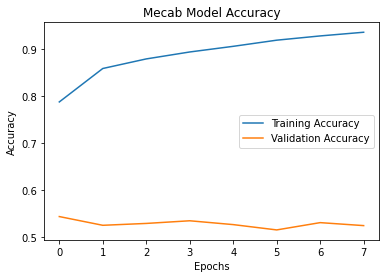

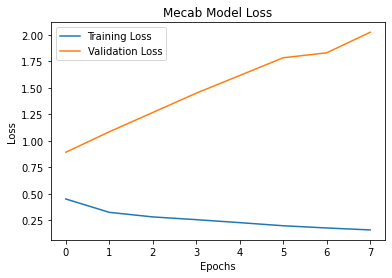

In [155]:
# Acc
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Mecab Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Mecab Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

####  그렇다. 이상하다 했다. 기계는 거짓말을 하지 않는다고. 분명 서브워드 방식이 더 좋아야했는데 결과가 비슷해서 당황했다. 
* 형태소 분석 쪽이 확실하게 학습이 저조한 모습이다. 정확도 0.5도 못 간다

In [156]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

1563/1563 [==============================] - 10s 6ms/step - loss: 2.0361 - accuracy: 0.5208
Test Loss: 2.0361, Test Accuracy: 0.5208


In [ ]:
from konlpy.tag import Okt

okt = Okt()

def tokenize_with_konlpy(sentence):
    return okt.morphs(sentence)  # 형태소 추출

# Train/Validation 데이터 토큰화
X_train_tokens = train_data['document'].apply(lambda x: tokenize_with_konlpy(x))
X_val_tokens = val_data['document'].apply(lambda x: tokenize_with_konlpy(x))

# Tokenizer 생성 및 학습
tokenizer = Tokenizer(num_words=16000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_tokens)

# 정수 시퀀스 변환
X_train_sequences = tokenizer.texts_to_sequences(X_train_tokens)
X_val_sequences = tokenizer.texts_to_sequences(X_val_tokens)

# 패딩
X_train_Okt = pad_sequences(X_train_sequences, maxlen=150, padding='post')
X_val_Okt = pad_sequences(X_val_sequences, maxlen=150, padding='post')

# 레이블
y_train_Okt = train_data['label'].values
y_val_Okt = val_data['label'].values

In [ ]:
# 초기화를 위해 다시 선언 
model = Sequential([
    Embedding(input_dim=16000, output_dim=128, input_length=150),  # 임베딩 레이어
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=0.2)), # 한 층 후 
    Dense(1, activation='sigmoid')  # 바로 이진 분류 출력
])

model.summary()

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습
history = model.fit(
    X_train_Okt, 
    y_train_Okt, 
    epochs=8,  # 학습 반복 횟수
    batch_size=128,  # 배치 크기
    validation_data=(X_val, y_val), 
    callbacks=[checkpoint],  # 콜백 추가
    verbose=1  
)

loss, accuracy = model.evaluate(X_val_Okt, y_val_Okt, verbose=1)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

In [ ]:
# Acc
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Okt Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Okt Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

### Okt랑 SentencePiece 보캡 사이즈 32000 정도만 더 시도해보고
### 모델 층 더 쌓아서 뭐가 더 최적화가 잘되는지도 시도해보고
### 전처리 방식을 바꿔서 어떻게 변하는지도 시도해보고